#### __Dataset__

Il dataset preso in esame rivela alcuni aspetti caratteristici dei fenomeni celesti, composto da tutti i domini chiave per l'esplorazione del cosmo. Alcune features presentano dei valori anomali rispetto all'insieme analizzato; tuttavia in questa circostanza la presenza di outliers è giustificata dal netto divario che contraddistingue ciascun fenomeno celeste da un proprio corrisposto.

Proseguendo, sono riportate delle brevi descrizioni dei domini trattati, in cui si evidezia:
- __Temperature__, informazioni termiche dell'entità
- __Luminosity__, rivela la brillantezza/luminosità della stella
- __Radius__, la dimensione spaziale dell'entità celeste, definendone la propria struttura
- __Magnitude__, ulteriore misura della luminosità di una stella, rappresenta la luce intrinseca del corpo celeste
- __Star Type__, tipologia dell'entità celeste analizzata, permette di definire una tassonomia dei ruoli coperti da ciuscuna stella analizzata
- __Spectral Class__, dominio che rappresenta l'unione di tre carratteristiche distinte di una stella, quali composizione chimica, temperatura e stadi evolutivi

Risorse:
- Link (https://www.kaggle.com/datasets/devendrasingh22/astronomical-data)

#### __Struttura dell'analisi__
Gli snippet di codice riportati di seguito sono utilizzati per implementare le funzioni di supporto all'analisi statistica del dataset __./dataset/cosmo_dataset.csv__, le quali possono essere suddivise in:
- Funzioni di __carattere generale__, adeguate per controlli ridondanti, mantenendo in questo modo una certa pulizia del codice 
- Funzioni __show_plots__, incentrate sulla visualizzazione grafica delle osservazioni date in input al metodo circoscritto, come ad esempio per l'_analisi dei residui_, _matrici di correlazione_ piuttosto che l'_analisi delle prestazioni dei modelli di classificazione_
- Funzioni legate all'__addestramento dei modelli__, in cui sono sviluppati determinati modelli predittivi, come _regressione logistica_ e il panorama offerto dal _Support Vector Machine_, in cui avviene il loro training pur di predirre la variabile di output _y'_, scelta in fase di splitting del dataset

L'analisi statistica si compone di certe fasi, quali:
- __EDA__
- __Splitting__
- __Mapping dei domini categorici__
- __Regressione lineare tra variabili numeriche__
- __Addestramento del modello - Valutazione delle performance__
- __Studio statistico sui risultati della valutazione incentrata sull'accuratezza__

In [145]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import metrics, svm
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

pd.options.mode.chained_assignment = None

In [146]:
from typing import Set

def union_categorical_field(field: str, df: pd.DataFrame) -> Set[str]:
    '''
        Funzione utilizzata per convertire variabili categoriche in 
        variabili numeriche

        field: dominio del dataset
        df: dataframe da cui saranno acquisiti i dati
    '''

    _set = set()

    entity = df[field]
    for item in entity:
        _set.add(item)

    return _set

In [147]:
def check_types_list(_type: type, _list: list) -> bool:
    '''
        Funzione utilizzata per effettuare un check sul tipo
        degli elementi contenuti nella lista

        _type: tipo atteso dagli elementi
        _list: lista degli elementi su cui è eseguito il check
    '''

    return all(isinstance(item, _type) for item in _list)

In [148]:
from pandas.api.types import is_numeric_dtype

def show_character_plots(field: str, df: pd.DataFrame):
    '''
        Funzione utilizzata per la visualizzazione dei grafici
        rispetto ad un dominio del dataset

        field: dominio del dataset di cui saranno realizzati 
        i grafici associati
        df: dataframe da cui saranno acquisiti i dati
    '''

    data = df[field]

    try:
        if is_numeric_dtype(data):
            plt.figure(figsize=(20, 6))

            plt.subplot(1, 2, 1)
            plt.title(f"{field} Box Plot")
            sns.boxplot(y=data, color="r")

            plt.subplot(1, 2, 2)
            plt.grid()
            plt.title(f"{field} Histogram")
            sns.histplot(data, color="r")

            plt.tight_layout()
            plt.show
        else:
            raise Exception
    except Exception:
        print(f"Il dominio {field} è categorico non numerico")

In [149]:
from typing import Tuple

def show_characters_plots(fields: Tuple[str, str], df: pd.DataFrame):
    '''
        Funzione utilizzata per la visualizzazione dei grafici
        rispetto ad alcuni domini del dataset

        fields: domini del dataset da cui sarà realizzato lo 
        scatter plot
        df: dataframe da cui saranno acquisiti i dati
    '''

    sub_df = df.select_dtypes(include="number")
    correlation_matrix = sub_df.corr(method="pearson")

    x = df[fields[0]]
    y = df[fields[1]]

    try:
        if is_numeric_dtype(x) and is_numeric_dtype(y):
            plt.figure(figsize=(20, 6))
            
            plt.subplot(1, 2, 1)
            plt.title(f"{fields[0], fields[1]} Scatter Plot")
            sns.scatterplot(x=x, y=y, hue=df["Star type"], palette="coolwarm")

            plt.subplot(1, 2, 2)
            plt.title("Correlation Matrix")
            sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)

            plt.tight_layout()
            plt.show()
        else: 
            raise Exception
    except Exception:
        print(f"Almeno un dominio inviato tra {fields} è categorico non numerico")

In [150]:
def show_linear_plots(X_label: str, y_label: str, x: pd.Series, y: pd.Series, y_pred: np.ndarray):
    '''
        Funzione utilizzata per la visualizzazione dei grafici
        rispetto ai risultati predetti dal modello di regressione
        lineare
        
        X_label: nome del dominio della variabile di input
        y_label: nome del dominio della variabile di output
        x: variabile di input
        y: variabile di output
        y_pred: variabile di output predetta dal modello
    '''

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.title("Points")
    plt.xlabel(X_label)
    plt.ylabel(y_label)
    plt.plot(x, y, "or", mfc="none")

    plt.subplot(1, 2, 2)
    plt.title("Straight Line")
    plt.xlabel(X_label)
    plt.ylabel(y_label)
    plt.plot(x, y, "or", mfc="none")
    plt.plot(x, y_pred)

    plt.tight_layout()
    plt.show()

In [179]:
def show_residuals_plots(y: pd.Series, y_pred: np.ndarray):
    '''
        Funzione utilizzata per la visualizzazione dei residui
        ottenuti successivamente alla predizione del modello di
        regressione lineare

        y: variabile di output
        y_pred: variabile di output predetta dal modello
    '''

    residuals = y - y_pred

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Histogram")
    sns.histplot(residuals, bins=30, kde=True, color="r")

    plt.subplot(1, 2, 2)
    plt.title("Residuals Q-Q Plot")
    stats.probplot(residuals, dist="norm", plot=plt)

    plt.tight_layout()
    plt.show()

In [152]:
def show_accuracy_plots(accuracies: list[float]):
    '''
        Funzione utilizzata per la visualizzazione dei grafici
        della lista della metrica scelta

        accuricies: lista delle accuratezze ottenute durante
        la fase di predizione del modello di classificazione
    '''

    try:
        if check_types_list(float, accuracies):
            plt.figure(figsize=(20, 6))

            plt.subplot(1, 2, 1)
            plt.title(f"Accuracies Box Plot")
            sns.boxplot(y=accuracies, color="r")

            plt.subplot(1, 2, 2)
            plt.grid()
            plt.title(f"Accuracies Histogram")
            sns.histplot(accuracies, color="r", bins=len(accuracies))

            plt.tight_layout()
            plt.show
        else:
            raise Exception
    except Exception:
        print("La lista in input deve contenere solamente valori numerici")

Tips: 
- Gli errori relativi a dati anomali possono essere rimossi oppure sovrascritto il loro contenuto mediante il _bound_ di riferimento.

In [153]:
from typing import Dict

def define_outliers(df: pd.DataFrame) -> tuple[Dict[str, int], pd.DataFrame]:
    '''
        Funzione utilizzata per la definizione degli outliers 
        che potrebbero possedere i domini numerici del dataset

        df: dataframe da cui saranno acquisiti i dati
    '''

    _df = df.select_dtypes(include="number").copy()

    q1 = _df.quantile(0.25)
    q3 = _df.quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    dict_outliers: Dict[str, int] = {column.strip(): 0 for column in _df.columns}

    for column in _df.columns[1:]:
        for i in range(len(_df[column])):
            if _df.iloc[i][column] > upper_bound[column]:
                _df.iloc[i][column] = upper_bound[column]
                dict_outliers[column] += 1

            if _df.iloc[i][column] < lower_bound[column]:
                _df.iloc[i][column] = lower_bound[column]
                dict_outliers[column] += 1

    return (dict_outliers, _df)

In [154]:
def split_dataframe(randomness: int, y_field: str, df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
        Funzione utilizzata per suddividere il dataframe
        in train set e test set

        randomness: grado di casualità per la suddivisione in 
        train set e test set
        y_field: dominio del dataset che rappresenta le
        variabili di output
        df: dataframe da cui saranno acquisiti i dati
    '''

    X = df.drop([y_field], axis=1)
    y = df[y_field]

    return train_test_split(X, y, train_size=.70, test_size=.30, random_state=2*randomness)

In [180]:
def linear_regression(X_label: str, y_label: str, X: pd.Series, y: pd.Series):
    '''
        Funzione utilizzata per eseguire una regressione
        lineare tra le varaibili date in input

        X_label: nome del dominio della variabile di input
        y_label: nome del dominio della variabile di output
        X: variabili di input univariata
        y: variabili di output 
    '''

    try:
        _, X_d = X.shape
    
        model = LinearRegression(n_jobs=-1).fit(X, y)

        y_pred = model.predict(X)

        print(f"In ordine: \n - m: {model.coef_} \n - q: {model.intercept_} \n - R^2: {model.score(X, y)}")
        
        show_linear_plots(X_label, y_label, X, y, y_pred)
        show_residuals_plots(y, y_pred)
    except Exception:
        print("La variabile in input non possiede una dimensione p=1")

In [156]:
def logistic_regression(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    '''
        Funzione utilizzata per effettuare una classificazione 
        secondo la regressione logistica e per definirne l'accuratezza

        X_train: sezione del dataset originario utilizzato per la 
        fase di addestramento del modello
        X_test: sezione del dataset originario utilizzato per la 
        predizione della variabile di output y'
        y_test: sezione del dataset originario utilizzato per la 
        fase di addestramento del modello   
        y_test: sezione del dataset originario contenente i valori 
        esatti della variabile di output y
    '''

    try:
        X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        X_test = preprocessing.MinMaxScaler().fit_transform(X_test)

        model = LogisticRegression(max_iter=100).fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
        
        print(f"Accuratezza del modello di regressione logistica: {accuracy}")
    except Exception:
        print("I dataset inviati non rispettano i vincoli di dimensione")

In [157]:
def evaluate_kernel(type_model: str, X_test: pd.DataFrame, y_true: pd.DataFrame, model: svm.SVC) -> metrics:
    '''
        Funzione utilizzata per valutare le prestazioni 
        di ciascun model attribuito a un certo kernel 
        rispetto alle variabili di input X e di output y

        type_model: tipologia di kernel scelto tra (linear, poly, rbf)
        X_test: sezione del dataset originario utilizzato per la
        predizione della variabile di output y'
        y_true: sezione del dataset originario contenente i valori 
        esatti della variabile di output y
        model: modello di machine learning pre-addestrato avente la
        propria kernel function pre-definita
    '''

    y_pred = model.predict(X_test)

    MR = np.mean(y_pred != y_true)
    accuracy = 1 - MR

    print(f"{type_model}: \n - \033[1mMisclassification ratio\033[0m: {round(MR*100, 2)} \n - \033[1mAccuratezza del modello\033[0m: {round(accuracy*100, 2)} \n")
    
    return metrics.confusion_matrix(y_true, y_pred)

In [158]:
def support_vector_machine(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    '''
        Funzione utilizzata per visualizzare le matrici
        di confusione per ciascun modello di classificazione
        distinti in base alla kernel function data

        X_train: sezione del dataset originario utilizzato per la 
        fase di addestramento del modello
        X_test: sezione del dataset originario utilizzato per la 
        predizione della variabile di output y'
        y_test: sezione del dataset originario utilizzato per la 
        fase di addestramento del modello   
        y_test: sezione del dataset originario contenente i valori 
        esatti della variabile di output y  
    '''

    try:
        plt.figure(figsize=(20, 6))

        X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        X_test = preprocessing.MinMaxScaler().fit_transform(X_test)

        linear_model = svm.SVC(kernel="linear", C=1).fit(X_train, y_train)
        cf_matrix_linear = evaluate_kernel("Lineare", X_test, y_test, linear_model)

        plt.subplot(1, 3, 1)
        plt.title("Linear Confusion Matrix")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        sns.heatmap(cf_matrix_linear, annot=True, cmap="Reds")

        poly_model = svm.SVC(kernel="poly", degree=3).fit(X_train, y_train)
        cf_matrix_poly = evaluate_kernel("Polinomiale", X_test, y_test, poly_model)

        plt.subplot(1, 3, 2)
        plt.title("Poly Confusion Matrix")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        sns.heatmap(cf_matrix_poly, annot=True, cmap="Reds")

        rbf_model = svm.SVC(kernel="rbf").fit(X_train, y_train)
        cf_matrix_rbf = evaluate_kernel("Esponenziale", X_test, y_test, rbf_model)

        plt.subplot(1, 3, 3)
        plt.title("Exponential Confusion Matrix")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        sns.heatmap(cf_matrix_rbf, annot=True, cmap="Reds")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("I dataset inviati non rispettano i vincoli di dimensione")

Tips:
- cv, cross-validation, indica il numero di suddivisioni del dataset
- utilizzare cv aiuta ad ottenere delle stime più accurate

In [159]:
from typing import List

def evaluate_model(K: int, df: pd.DataFrame, _svm: svm.SVC) -> List[int]:
    '''
        Funzione utilizzata per valutare la bontà del modello
        di classificazione in base al kernel scelto

        K: numero di iterazioni da eseguire
        df: dataframe da cui saranno acquisiti i dati
        _svm: modello svm caratterizzato da una propria kernel 
        function
    '''

    print("Accuratezza del modello in ordine:", end="\n")

    accuracies = []
    for i in range(K):
        tuple_dataframes = split_dataframe(randomness=i, y_field="Spectral Class", df=df)

        X_train = tuple_dataframes[0]
        X_test = tuple_dataframes[1]

        y_train = tuple_dataframes[2]
        y_test = tuple_dataframes[3]

        model = _svm.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        scores = cross_val_score(_svm, X_train, y_train, scoring="accuracy", cv=KFold(n_splits=5, shuffle=True, random_state=20+2*i))
        mean_accuracy = round(scores.mean()*100, 2) 

        recall = metrics.recall_score(y_test, y_pred, average="weighted", zero_division=0)
        mean_recall = round(np.mean(recall)*100, 2)
        
        precision = metrics.precision_score(y_test, y_pred, average="weighted", zero_division=0)
        mean_precision = round(np.mean(precision)*100, 2)

        print(f"- \033[1mStep {i+1}\033[0m:\n\t- \033[1mPrecisione\033[0m: {mean_precision}\n\t- \033[1mSensitività\033[0m: {mean_recall}\n\t- \033[1mAccuratezza\033[0m: {mean_accuracy}", end="\n")
        
        accuracies.append(mean_accuracy)

    return accuracies

Tips:
- Applico l'intervallo di confidenza sull'accuracy
- Mentre per sensibilità e precisione riporto solamente la stampa

In [160]:
def observe_model_accuracy(type_model: str, K: int, df: pd.DataFrame) -> List[np.float128]:
    '''
        Funzione utilizzata per definire uno storico delle performance
        dei modelli di classificazione svm principali

        type_model: tipoligia di kernel scelto tra (linear, poly, rbf)
        K: numero di iterazioni da eseguire
        df: dataframe da cui saranno acquisiti i dati
    '''

    try:
        match(type_model):
            case "linear":
                accuracies = evaluate_model(K, df, svm.SVC(C=10, kernel="linear", class_weight="balanced"))
            case "poly":
                accuracies = evaluate_model(K, df, svm.SVC(kernel="poly", degree=3, class_weight="balanced"))
            case "rbf":
                accuracies = evaluate_model(K, df, svm.SVC(kernel="rbf", class_weight="balanced"))
            case _:
                raise Exception
            
        _mean = round(np.mean(accuracies), 2)

        print(f"\nL'\33[1maccuratezza media\33[0m del modello {type_model} risulta: {_mean}")
            
        return accuracies
    except Exception as e:
        print(f"\nLa tipologia di kernel {type_model} non rientra tra quelle gestite")

In [182]:
def define_confidence_interval(_list):
    '''
        Funzione utilizzata per il calcolo dell'intervallo
        di confidenza con livello di confidenza pari a 0.05

        _list: list di valori numerici che definiscono la metrica
        scelta in fasi precedenti
    '''

    try:
        if check_types_list(float, _list):
            n = len(_list)

            std_accuracy = np.std(_list)
            mean_accuracy = np.mean(_list)

            confidence_interval = stats.t.interval(0.95, n-1, loc=np.mean(_list), scale=stats.sem(_list))

            print(f"L'intervallo di confidenza con livello di confidenza \u03B1=0.05 risulta: [{confidence_interval[0]}, {confidence_interval[1]}]")
        else: 
            raise Exception
    except Exception:
        print("La lista in input deve contenere solamente valori numerici")

Tips:
- Un dataset è una tabella contenente certi valori, in cui le colonne rappresentano i _domini_, mentre le righe le differenti _entità_. Dal punto di vista matematico un dataset, preso un certo numero di righe __N__ e un certo numero di colonne __D__, rappresenta una matrice avente dimensione per _N x D_.
- Tramite la libreria pandas ho caricato il dataset, ora lo step successivo consiste in una fase di osservazione preliminare delle caratteristiche del dataset preso in esame

In [162]:
df = pd.read_csv("../dataset/star_dataset.csv")

#### __EDA__

In [163]:
N, d = df.shape 
print(f"Dimensione del dataset preso in esame {N, d}")

Dimensione del dataset preso in esame (240, 7)


In [164]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [165]:
try:
    for column in df.columns:
        _match = re.findall(r"(\(.*?\))", column)[0]
        index = column.find(_match)
        new_name = column[:index].strip()

        df.rename(columns={column: new_name}, inplace=True)
except Exception:
    pass

df.head()

,Temperature,Luminosity,Radius,Absolute magnitude,Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Come è possibile osservare il dataset è caratterizzato da alcuni domini inutili se non ridondanti, è bene allora in questa circostanza eliminare tutto ciò che sia superfluo. Quindi vado ad eliminare tutti gli extra_field tramite una semplice iterazione sui singoli domini che compongano il dataset.

Tips:
- Dal nuovo dataframe potrei realizzare un sub-dataframe per effettuare delle indagini statistiche
- La preparazione dei dati rappresenta la fase più lunga e complessa, dal suo svolgimento dipende non solo l'analisi successiva, ma anche l'addestramento dei modelli di predizione.

In [166]:
df = df.dropna()
N, d = df.shape 

print(f"Dimensione del dataset preso in esame successivamente al .dropna() {N, d}")

Dimensione del dataset preso in esame successivamente al .dropna() (240, 7)


Tips:
- È possibile notare che a livello di variabili categoriche il dataset preso in esame risulta essere sbilanciato rispetto alla _classe spettrale_ "M", pertanto il fatto che sia sbilanciato potrebbe propagarsi sulle prestazioni dei modelli di classificazione

In [167]:
classes = df["Spectral Class"]
_dict = df["Spectral Class"].value_counts().to_dict()

print(_dict)

{'M': 111, 'B': 46, 'O': 40, 'A': 19, 'F': 17, 'K': 6, 'G': 1}


In ordine:
- Indagine univariata _(basata su un solo carattere)_
- Indagine bivariata _(basata su due caretteri --> scatter)_
- Indagine multivariata _(basata su più d due caratteri -> matrix)_

Tips:
- Sicuramente alcuni domini all'interno del dataset presentano degli outliers _(dati anormali rispetto al resto dei dati presenti all'interno del dataset)_, in queste cirostanze è necessaria la loro rimozione affinchè non abbiano ripercussioni su operazioni successive, come sull'accuratezza dei modelli e a portare a previsioni errate.
- Pertanto impiegando un _blox plot_ posso accertarmi della loro presenza a livello grafico per poi definire il metodo necessario per la loro rimozione _(a titolo esemplificativo la feature "Cholesterol_Level" rappresenta l'effettività più lampante)_. 

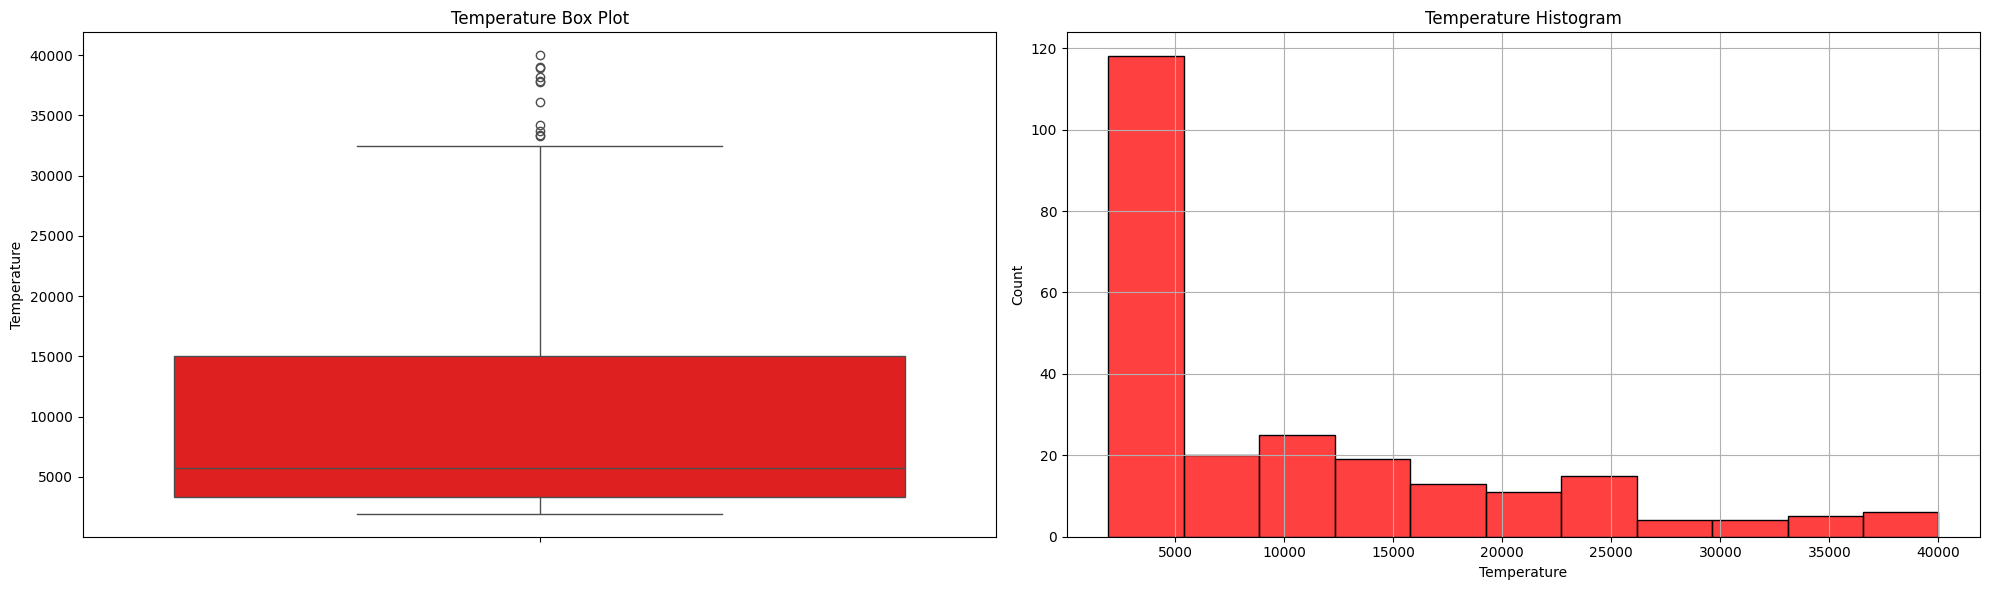

In [168]:
show_character_plots("Temperature", df)

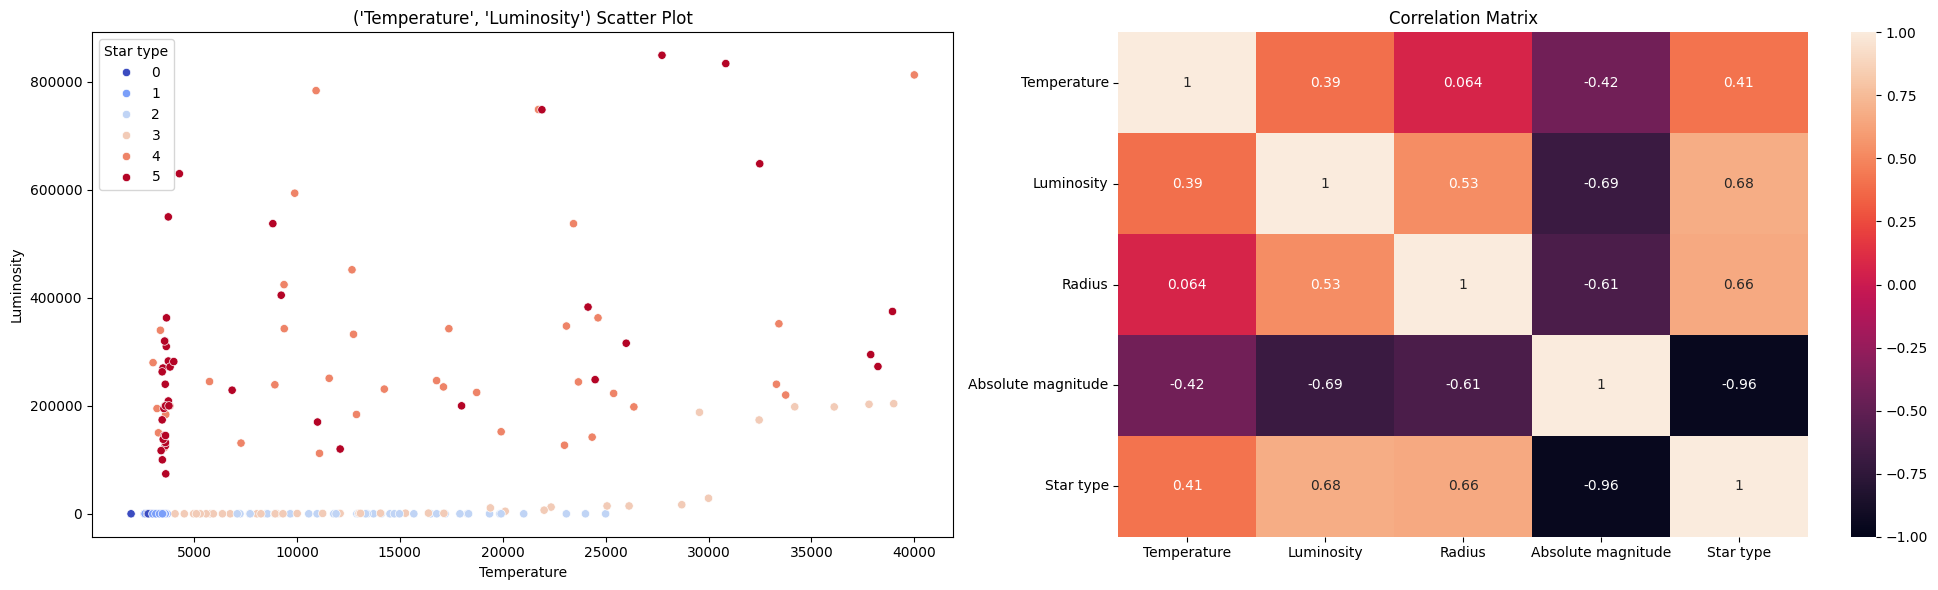

In [169]:
show_characters_plots(("Temperature", "Luminosity"), df)

Tips:
- In questo contesto la presenza di outliers è giustificata dal fatto che la maggior parte dell'entità è carratterizzata da stelle di tipologia "rossa", pertanto altri dati potrebbero essere considerati al di fuori del range inter-quartile.
- Tramite il metodo sono individuati gli "outliers" fittizi.

In [170]:
_dict, _ = define_outliers(df)
_dict

{'Temperature': 0,
 'Luminosity': 12,
 'Radius': 40,
 'Absolute magnitude': 0,
 'Star type': 0}

Nozioni:
- Effettuate le prime fasi di pulizia dei dati del dataset applico ora delle indagini statistiche tra cui la Matrice di Correlazione.
- La Matrice di Correlazione è una tabella che mostra i coefficenti di correlazione tra due o più variabili. Il coeficciente può assumere un valore compreso tra _[-1, 1]_, dove 1 indica una correlazione perfetta (diretta proporzionalità), -1 indica una correlazione negativa perfetta (inversamente proporzionali) e 0 rappresenta nessuna correlazione tra le variabili prese in esame. (Prendere in considerazione anche gli appunti sul quaderno)
- Per la definizione della matrice di correlazione vado ad ignorare i campi in cui siano presenti dati categorici (dato che non esprimono strettamente delle carratteristiche numeriche)
- Come individuato dalla matrice di correlazione è possibile osservare che la maggior parte dei domini numerici, se non tutta non possiede una correlazione evidente, ne positiva ne negativa, ma rappresentano piuttosto tutti caratteri non dipendenti, data la loro stretta vicinanza all'intorno 0. Tuttavia possiamo distinguere casi in cui sia presente una correlazione positiva piuttosto che una correlazione negativa.
- Ora provo ad eliminare gli outlier dal sub dataframe, per osservare se sia presente un miglioramento della matrice di correlazione
- Il particolare tipo di scatter plot ottenuto, ossia _diagramma Hertzsprung-Russell_, mostra come le stelle si distribuiscano in base alla temperatura e alla luminisità. Inoltre si ha che: le stelle O/B (calde e luminose) sono poste in alto, segnate con il colore rosso; stelle (calde ma meno luminose) sono poste centralmente; infine le stelle (fredde e poco luminose) sono poste in basso a dx e sx.

#### __Regressione lineare__

Tips:
- Mettere a confronto domini che di natura sono variabili numeriche, quindi non la conversione da categorico
- Devo utilizzare la __regressione__ qualora la y sia un valore __numerico__ (predire --> Temperature, Luminosity)
- Devo seguire un approccio di __classificazione__ qualora la variabile da predire è di tipo __categorico__ (predire -> Star color, Spectral class)

In ordine: 
 - m: [182.67977484] 
 - q: 63864.43153126554 
 - R^2: 0.27721880798570075


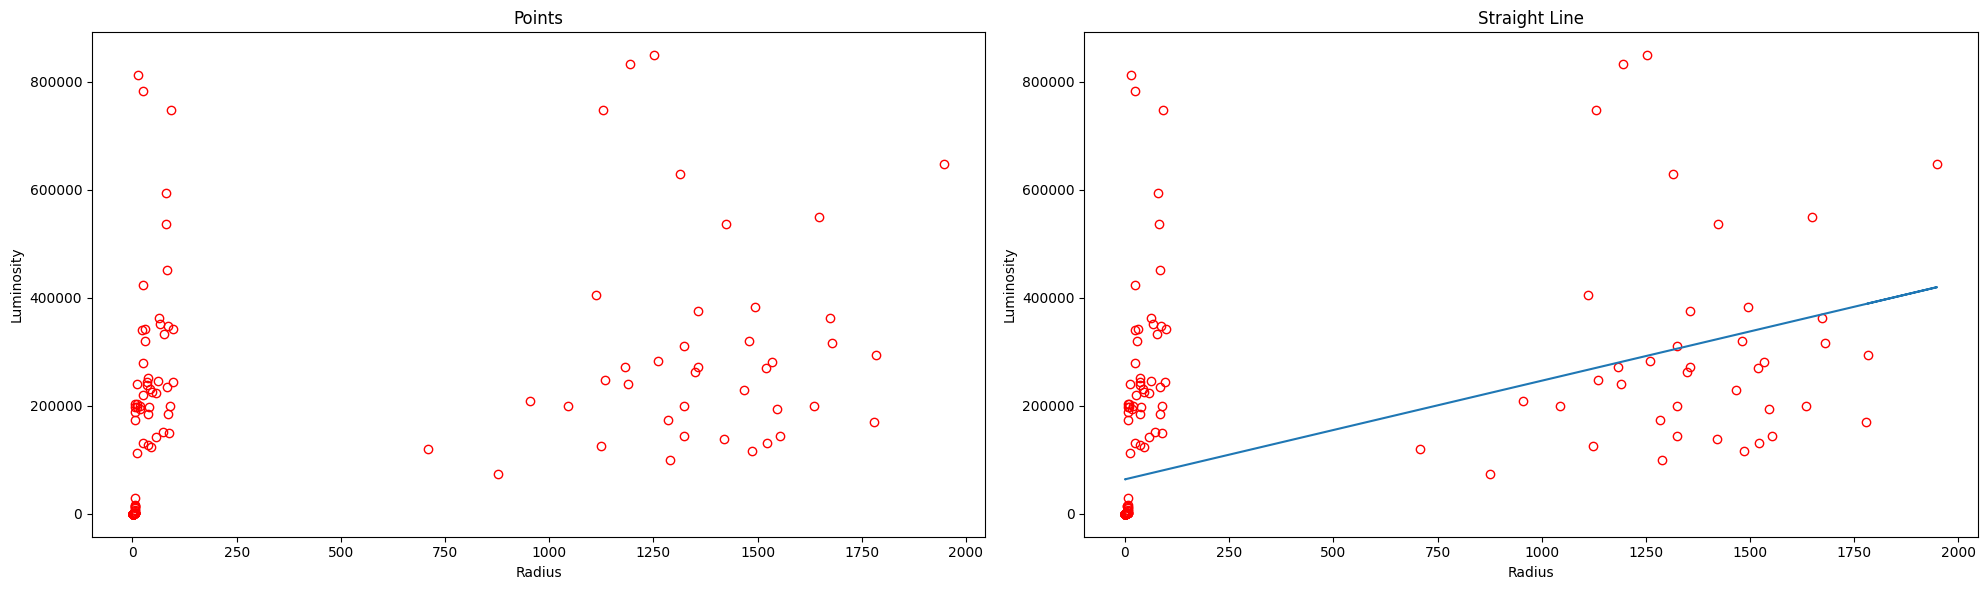

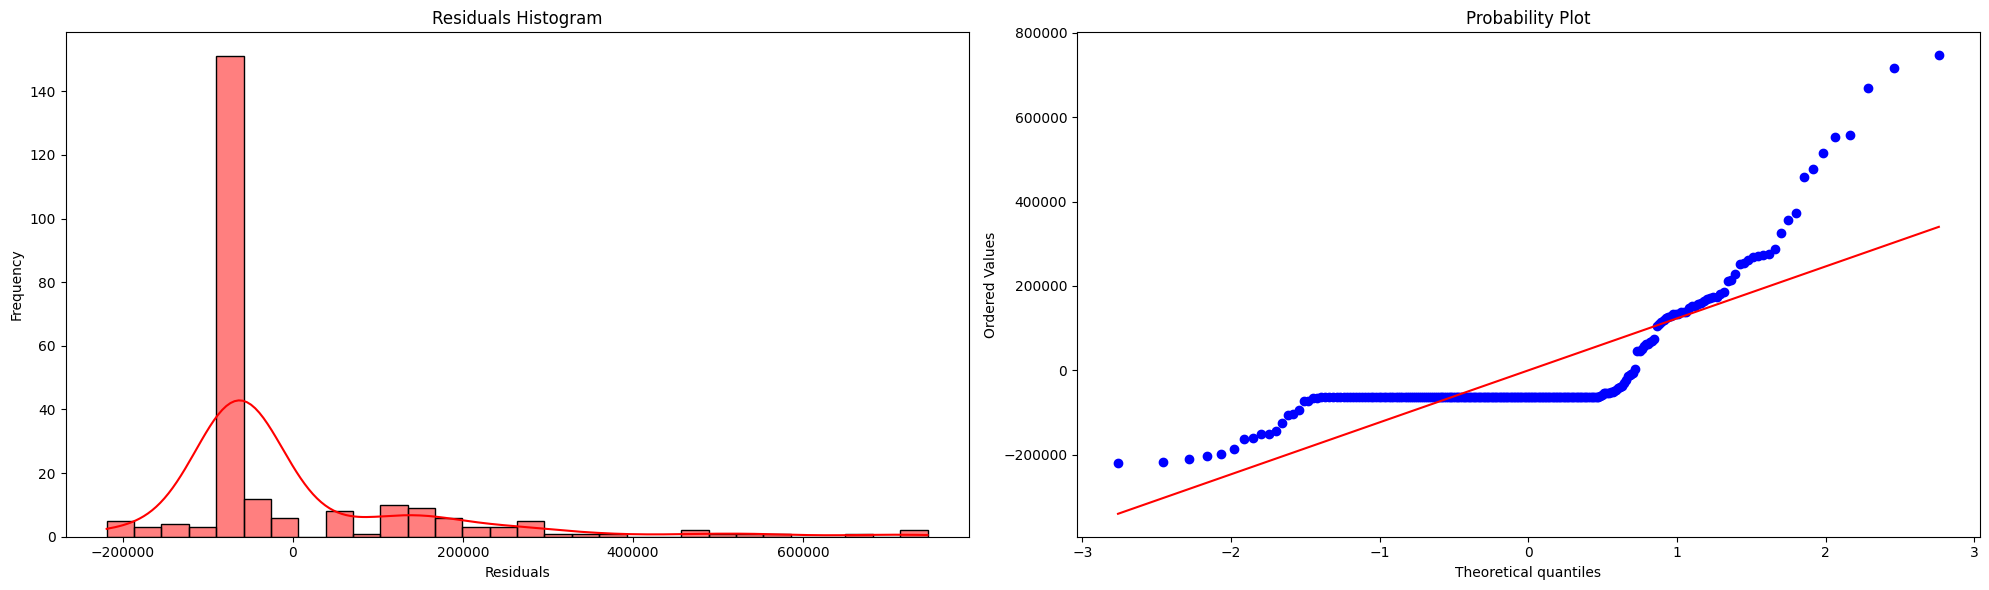

In [181]:
_, _df = define_outliers(df)

X_label = "Radius" 
y_label = "Luminosity"

X = _df[[X_label]]
y = _df[y_label]

linear_regression(X_label, y_label, X, y)

Tips:
- Posticipo la conversione del categorico affinchè i domini convertiti non possano essere presi come domini per una regressione lineare

#### __Mapping dei domini categorici__

In [172]:
encoder = preprocessing.LabelEncoder()
df_category = df.select_dtypes(include=["object", "category"])

print("In ordine:", end="\n")
for column in df_category.columns:
    _set = union_categorical_field(column, df)
    values = encoder.fit_transform([item for item in _set])
    _dict = {key: int(value) for key, value in zip(_set, values)}

    print(f"- Dominio \033[1m{column}\033[0m del dataset convertito in {_dict}", end="\n")

    df[column] = df_category[column].map(_dict)

In ordine:
- Dominio Star color del dataset convertito in {'White': 3, 'Red': 2, 'Blue-White': 1, 'Yellow-White': 4, 'Blue': 0}
- Dominio Spectral Class del dataset convertito in {'F': 2, 'A': 0, 'G': 3, 'M': 5, 'K': 4, 'O': 6, 'B': 1}


#### __Splitting__

In [173]:
X_train, X_test, y_train, y_test = split_dataframe(randomness=1, y_field="Star type", df=df)

Tips:
- I residui, ossia la differenza dettata dalle variabili di output e i valori predetti, permettono di stabilire la bontà del modello. 
- Tipicamente la loro definizione ed osservazione avviene mediante l'impiego di alcuni grafici come istogrammi e qq grafico, dove qq sta per _quantile-quantile_
- I residui, affinchè il modello possa essere definito buono/accettabile, dovrebbero seguire una distribuzione normale come media pari a 0 e una varianza qualsiasi costante
- A livello di istogramma dovrebbero disporsi in maniera simmetrica e seguendo l'andamento a "campana"
- A livello di grafico q-q invece i residui dovrebbero seguire l'andamento della bisetrice, affinchè quindi sia possibile affermare che le inferenze statistiche sono valide
- Inoltre l'analisi dei residui permette di definire la presenza di potenziali outliers. i quali rappresentano dati anomali, ossia che si trovano al di sotto o al di sopra del centro dei dati pari a 1.5 volte

#### __Addestramento del Modello - Valutazione delle Performance__ 

Tips:
- Dato che la rigressione logistica per una dimensione delle variabili di input > 2 richiede un'approssimazione dei risultati per stabilirne la bontà, adeguo un approccio alternativo, dato dall'accuratezza e dalla matrice di confusione
- L'accuratezza definisce il ratio delle predizioni corrette sul totale. Tuttavia questo approccio tende a nascondere alcuni dettagli che possano essere utilizzati per evidenziare meglio le prestazioni del modello
- Per questo è utilizzata la matrice di confuzione, la quale stabilisce il numero esatto di predizioni errate effattuate dal modello. 

In [174]:
logistic_regression(X_train, X_test, y_train, y_test,)

Accuratezza del modello di regressione logistica: 90.28


Lineare: 
 - Misclassification ratio: 23.61 
 - Accuratezza del modello: 76.39 

Polinomiale: 
 - Misclassification ratio: 5.56 
 - Accuratezza del modello: 94.44 

Esponenziale: 
 - Misclassification ratio: 5.56 
 - Accuratezza del modello: 94.44 



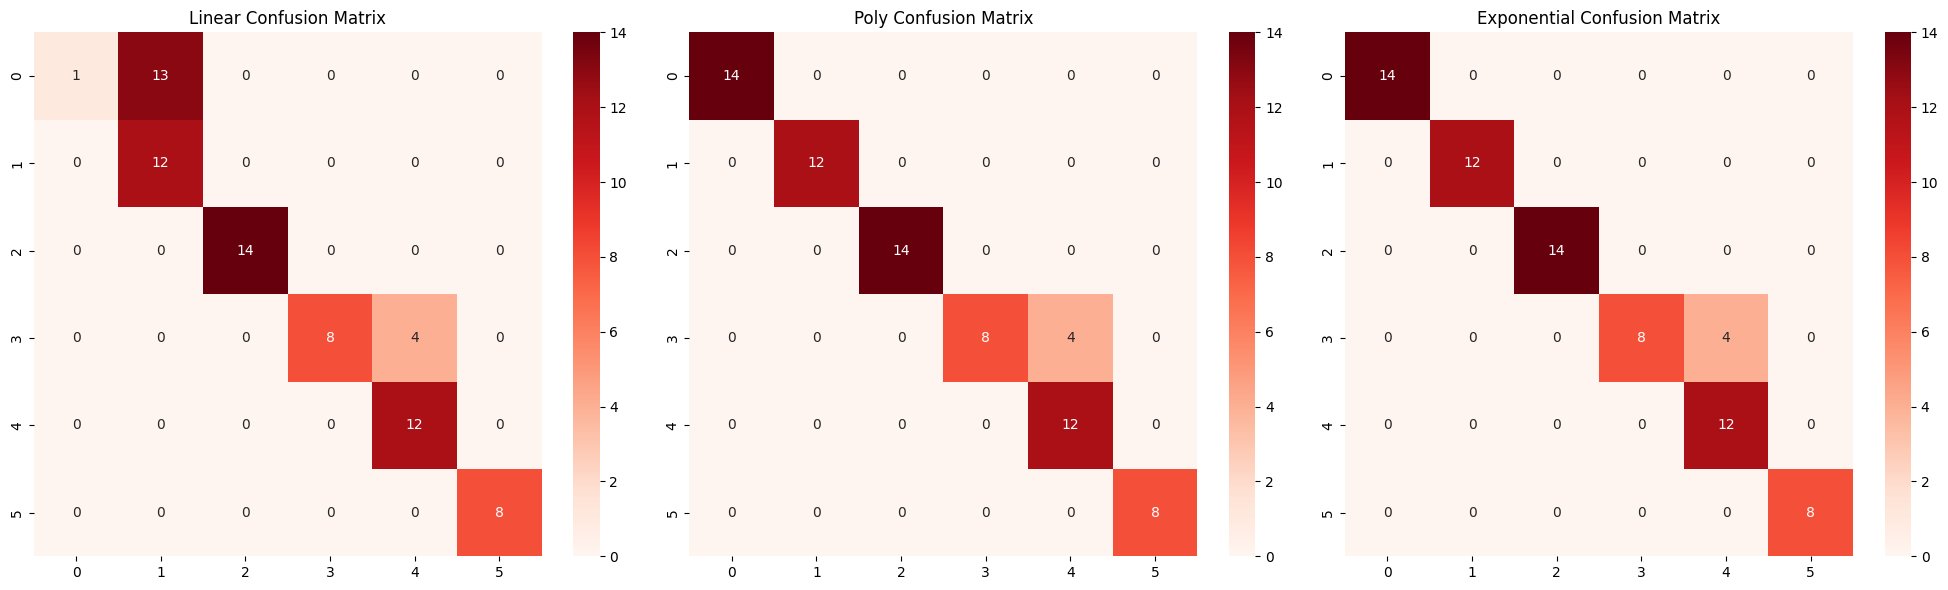

In [175]:
support_vector_machine(X_train, X_test, y_train, y_test)

In [176]:
X_train, X_test, y_train, y_test = split_dataframe(randomness=1, y_field="Star color", df=df[["Luminosity", "Temperature", "Star color"]])

logistic_regression(X_train, X_test, y_train, y_test)

Accuratezza del modello di regressione logistica: 73.61


Tips:
- Il fatto di aver impiegato tra loro x1 e x2 non fortemente correlate ha permesso di ottenere un migliore livello di accuratezza, infatti con Luminosity-Radius ho ottenuto un livello di score pari al 52% mentre tra Luminosity-Temperature ho ottenuto uno score migliore attorno al 74%, prova anche con Temperature-Radius ottenuta incidenza minore

#### __Studio statistico sui risultati della valutazione__

Tips:
- Fino ad ora sono andato a definire la robustezza/qualità dei modelli in base alla sola distinzione della kernal function data al Support Vector Machine
- Ora adeguo un'analisi del modelli di ML attraverso una distinzione del Simple Randome Sample, ossia vado ad acquisire il campione dei dati dal dataset applicando prima una randomness, esprimendo quindi un certo livello di casualità, garantendo in questo modo una diversa suddivisione dei dati a ogni iterazione, per poi applicare _k-fold Cross-Validation_, sempre in ottica di misurare la bontà/qualità del modello.
- Per la _Cross-Validation_ come metrica principale da cui poi definirò la media è l'_accuratezza_, attuando quindi m-accuracy =  sommatoria di ciascuna accuracy/k

In [33]:
K = 10

accuracies = observe_model_accuracy("linear", K, df)

Accuratezza del modello in ordine:
- Step 1:
	- Precisione: 84.3
	- Sensitività: 84.72
	- Accuratezza: 82.73
- Step 2:
	- Precisione: 84.81
	- Sensitività: 86.11
	- Accuratezza: 85.12
- Step 3:
	- Precisione: 80.24
	- Sensitività: 81.94
	- Accuratezza: 88.72
- Step 4:
	- Precisione: 88.67
	- Sensitività: 86.11
	- Accuratezza: 85.1
- Step 5:
	- Precisione: 80.74
	- Sensitività: 79.17
	- Accuratezza: 88.09
- Step 6:
	- Precisione: 95.91
	- Sensitività: 95.83
	- Accuratezza: 83.99
- Step 7:
	- Precisione: 84.89
	- Sensitività: 79.17
	- Accuratezza: 84.51
- Step 8:
	- Precisione: 84.98
	- Sensitività: 87.5
	- Accuratezza: 86.93
- Step 9:
	- Precisione: 96.06
	- Sensitività: 93.06
	- Accuratezza: 85.15
- Step 10:
	- Precisione: 86.08
	- Sensitività: 86.11
	- Accuratezza: 87.56

L'accuratezza media del modello linear risulta: 85.79


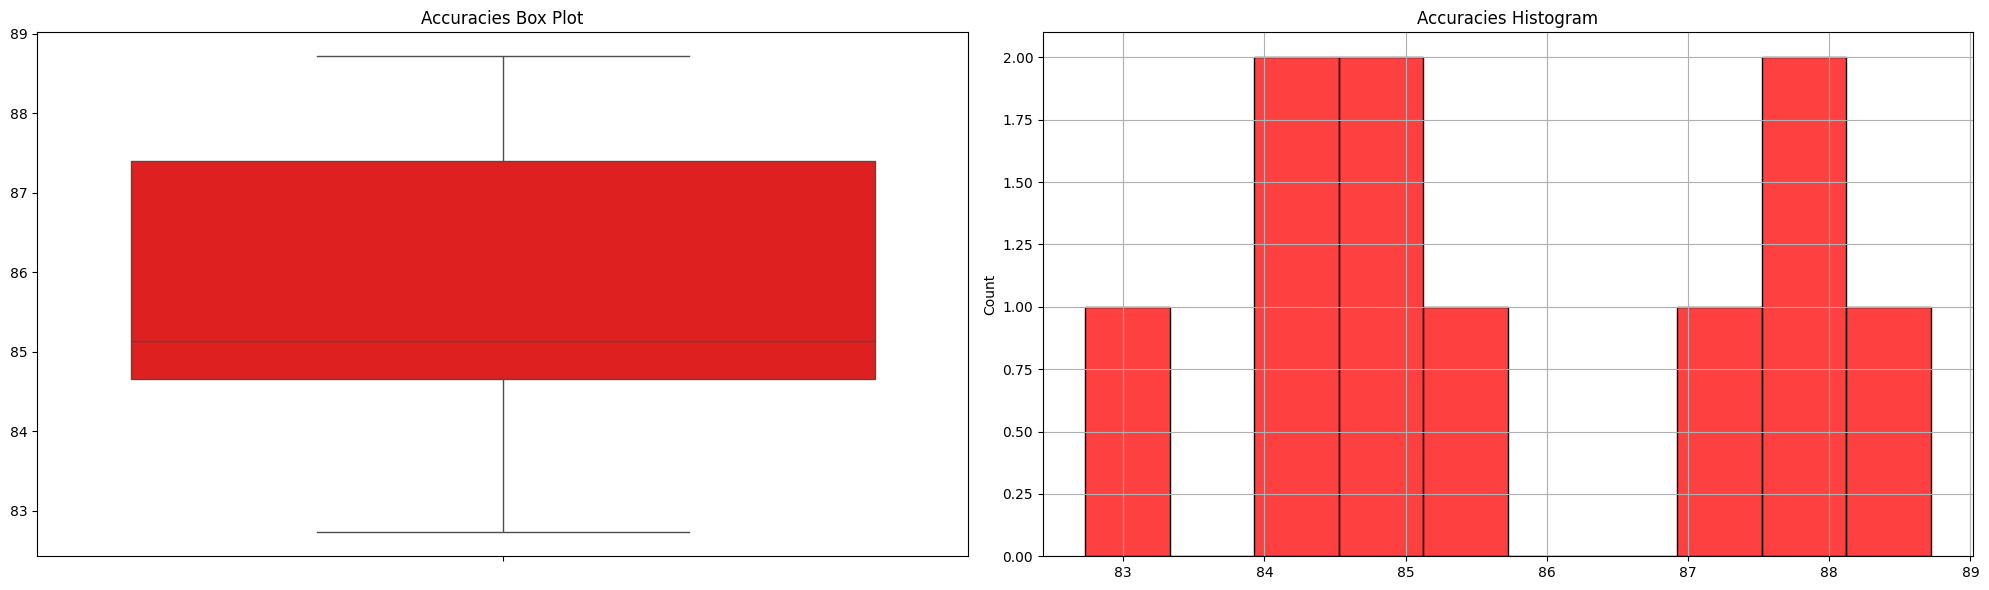

In [177]:
show_accuracy_plots([accuracy.item() for accuracy in accuracies])

In [178]:
define_confidence_interval([accuracy.item() for accuracy in accuracies])

L'intervallo di confidenza con livello di confidenza α=0.05 risulta: [84.40196998984591, 87.1780300101541]
